In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

# Remover warnings que atrapalham no momento de exportar
warnings.filterwarnings('ignore')

sns.set()

# Análise de dados e modelos para SQL Injection


Carregando os dados

In [2]:
logs_df = pd.read_csv("logs.csv")
logs_df.head()

,ipaddress,dateandtime,url,statuscode,bytessent,refferer,useragent,malicious
0,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0
1,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0
2,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0
3,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0
4,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0


In [3]:
logs_df.shape

(8897, 8)

In [4]:
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8897 entries, 0 to 8896
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ipaddress    8897 non-null   object
 1   dateandtime  8897 non-null   object
 2   url          8897 non-null   object
 3   statuscode   8897 non-null   int64 
 4   bytessent    8897 non-null   int64 
 5   refferer     8897 non-null   object
 6   useragent    8897 non-null   object
 7   malicious    8897 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 556.2+ KB


In [5]:
logs_df["url_size"] = logs_df["url"].apply(lambda x: len(x))
logs_df.head()

,ipaddress,dateandtime,url,statuscode,bytessent,refferer,useragent,malicious,url_size
0,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
1,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
2,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
3,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
4,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34


In [6]:
malicious_df = logs_df.loc[logs_df["malicious"] == 1]
not_malicious_df = logs_df.loc[logs_df["malicious"] == 0]

Não vou prestar atenção, nestes logs, aos ips e datas porque eles são totalmente arbitrarios, uma vez que eu gerei os dados, portanto não representam a realidade. Mas em logs da vida real talvez sejam features uteis. Por exemplo uma métrica: quantas requisições um determinado IP realisou nos últimos 30 minutos? No ultimo dia? Suponho que esse tipo de feature ajudaria modelos a determinar se requisições são maliciosas ou não.


# Análise exploratória

Aqui busco entender como cada coluna se relaciona com o tipo de requisição.

## Bytes sent

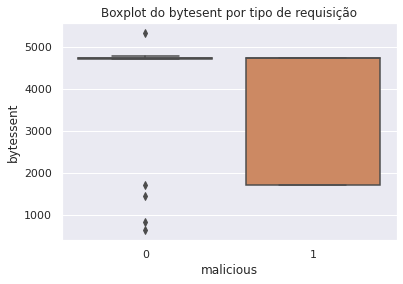

In [7]:
plt.title("Boxplot do bytesent por tipo de requisição")
sns.boxplot(data=logs_df, x="malicious", y="bytessent")
plt.show()

Muito estranho, parece que as requisições maliciosas não tem valores extremos, ou se tem, são muito poucos. Vou investigar mais afundo.

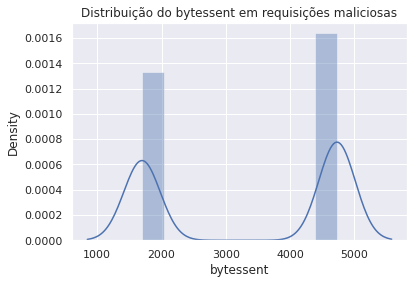

In [8]:
plt.title("Distribuição do bytessent em requisições maliciosas")
sns.distplot(malicious_df["bytessent"])
plt.show()

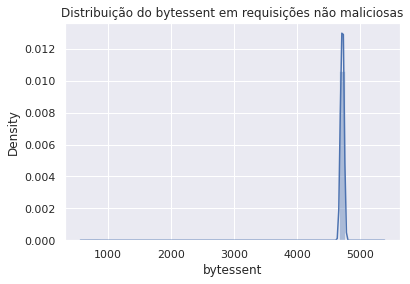

In [9]:
plt.title("Distribuição do bytessent em requisições não maliciosas")
sns.distplot(not_malicious_df["bytessent"])
plt.show()

Daqui fica visivel que requisições maliciosas possuem valores em torno de 2000 e de 5000, isso explica o boxplot não ter valores extremos, mas o tamanho do valor interquantil é grande. Já requisições "boas" possuem valores proximos de 5000.

Concluo que não é possivel usar somente está feature para o modelo, mas ela é útil pois apenas requisições maliciosas possuem bytessent proximos de 2000.

## Status code

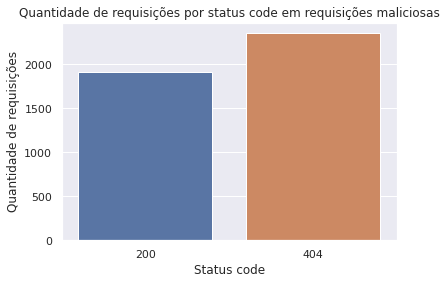

In [10]:
val = malicious_df["statuscode"].value_counts()
plt.title("Quantidade de requisições por status code em requisições maliciosas")
sns.barplot(list(val.index), list(val))
plt.xlabel("Status code")
plt.ylabel("Quantidade de requisições")
plt.show()

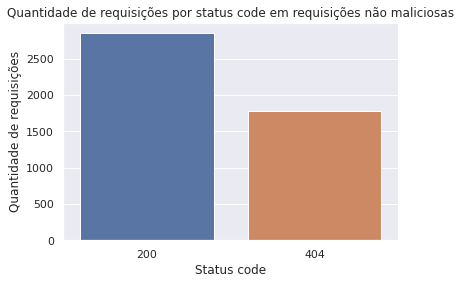

In [11]:
val = not_malicious_df["statuscode"].value_counts()
plt.title("Quantidade de requisições por status code em requisições não maliciosas")
sns.barplot(list(val.index), list(val))
plt.xlabel("Status code")
plt.ylabel("Quantidade de requisições")
plt.show()

Esses dados dependem da maneira de como eles foram gerados, principalmente os dados de requisições não maliciosas. Eu não me atentei a isso quando gerei, mas penso que faz sentido que requisições maliciosas  tenham uma quantidade maior de status code com erro, isto é, entrar 400 e 599, pois o hacker está testando urls com possiveis vulnerabilidades.

Uma boa feature para ser usada, não da maneira como esta (dado numérico),  talvez como uma categoria os modelos consigam entender melhor.

## URls size

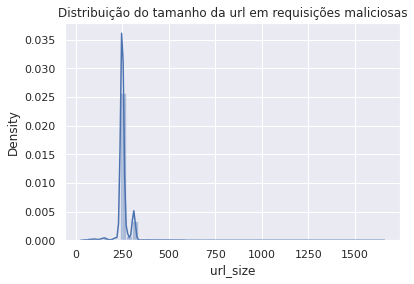

In [12]:
plt.title("Distribuição do tamanho da url em requisições maliciosas")
sns.distplot(malicious_df["url_size"])
plt.show()

In [13]:
malicious_df["url_size"].min()

48

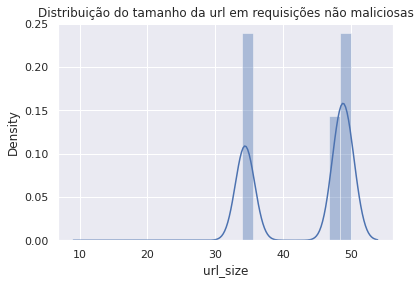

In [14]:
plt.title("Distribuição do tamanho da url em requisições não maliciosas")
sns.distplot(not_malicious_df["url_size"])
plt.show()

Está é uma métrica que é muito boa para separar as requisições. Requisições em que a URL é menor do que 50 são não maliciosas e requisições acima disso, são. Mas essa é uma feature muito especifica desse conjunto de dados pois a url "/vulnerabilities/sqli_blind/?id=" é curta. Em aplicaçãoes em que a url a ser explorada também é grande, talvez essa feature não separe tão bem os dados. 
De qualquer maneira vou criar um baseline com essa feature e tentar melhorar os modelos sobre esse baseline.

# Modelos

In [15]:
logs_df.head()

,ipaddress,dateandtime,url,statuscode,bytessent,refferer,useragent,malicious,url_size
0,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
1,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
2,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
3,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
4,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34


Antes de qualquer coisa, vou ver se os dados estão balanceados.

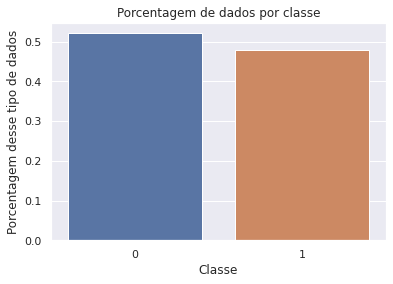

In [16]:
t = logs_df.malicious.value_counts()
qtd_logs = logs_df.shape[0]

plt.title("Porcentagem de dados por classe")
sns.barplot(x=t.index, y=t.values/qtd_logs)
plt.xlabel("Classe")
plt.ylabel("Porcentagem desse tipo de dados")
plt.show()

Concluimos que os dados estão balanceados por classe. Portanto prossigamos com a separação dos dados em treino e teste.

In [17]:
logs_df.head()

,ipaddress,dateandtime,url,statuscode,bytessent,refferer,useragent,malicious,url_size
0,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
1,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
2,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
3,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34
4,192.168.1.11,28/Feb/2021:19:39:28 -0400,/vulnerabilities/sqli_blind/?id=1,200,4696,"""-""",ApacheBench/2.3,0,34


In [18]:
X = logs_df.loc[:, ["statuscode", "bytessent", "url_size"]]
y = logs_df.loc[:, "malicious"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

O primeiro modelo a ser testado, é o que utiliza somente o tamanho da url para classificar se a url é maliciosa ou não.

In [19]:
y_predict_naive = X_train.url_size.apply(lambda x: 0 if x <= 50 else 1)

In [20]:
confusion_matrix(y_train, y_predict_naive)

array([[3243,    0],
       [   3, 2981]])

In [21]:
accuracy_score(y_train, y_predict_naive)

0.9995182270756383

Veja que, como esperado, o modelo performou muito bem. Errou apenas 4 requisições que eram malicionas e foi classificado como não maliciosa no conjunto de dados de treino. Porém, este modelo performa bem neste conjunto de dados, mas suponha que se tenha um serviço com a URL suficientemente grande, neste caso, maior que 50, então seria classificada com maliciosas. 

Na verdade, manter esta feature para classificar este conjunto de dados pode ser prejudicial, pois os modelos também colocariam maior peso sobre ela na hora de treinar e "esqueceriam" da outras, por exemplo, veja no modelo de regressão logistica abaixo.

In [22]:
lg_clf = LogisticRegression()
lg_clf.fit(X_train, y_train)

LogisticRegression()

In [23]:
lg_clf.coef_, lg_clf.intercept_

(array([[-0.01511973, -0.00479138,  0.80037785]]), array([-23.41683911]))

In [24]:
X.columns

Index(['statuscode', 'bytessent', 'url_size'], dtype='object')

Veja que os pesos da regressão logistica deram mais importancia para o tamanho da url e as outras ficaram "menos importantesse", da ordem de $10^{-1}$

In [25]:
y_predict_lg = lg_clf.predict(X_train)

In [26]:
confusion_matrix(y_train, y_predict_lg)

array([[3243,    0],
       [   0, 2984]])

In [27]:
accuracy_score(y_train, y_predict_lg)

1.0

Entretanto veja que com os dados adicionais nos conseguimos aumentar a acurácia para 1. Ou seja, eles ajudaram a clasificar as 4 requisições erradas. Mas acho que o um baseline bom para este conjunto de dados será usando somente o bytessent e statuscode como feature.

In [28]:
X_train = X_train.loc[:, ["statuscode", "bytessent"]]
X_test = X_test.loc[:, ["statuscode", "bytessent"]]

In [29]:
lg_clf = LogisticRegression()
lg_clf.fit(X_train, y_train)

LogisticRegression()

In [30]:
y_predict_lg = lg_clf.predict(X_test)

In [31]:
confusion_matrix(y_test, y_predict_lg)

array([[ 878,  513],
       [   0, 1279]])

In [32]:
accuracy_score(y_test, y_predict_lg)

0.8078651685393259

Então com o modelo de regressão e usando os parametros padrões dele junto com conjunto de dados anterior, conseguimos uma acuracia de 80% nos dados de teste.